In [1]:
## Global imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Visualize dataset

In [2]:
from load_data import load_data

housing = load_data('./data', 'housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


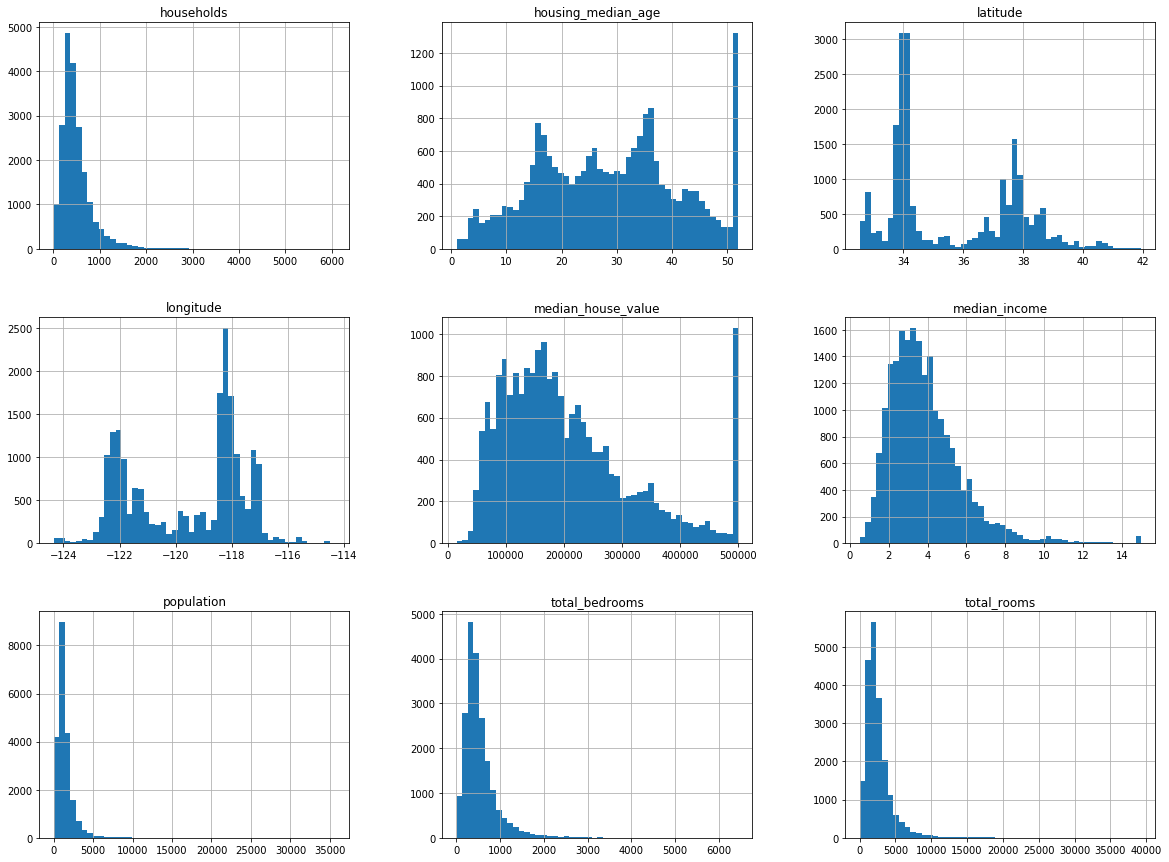

In [3]:
housing.hist(bins=50, figsize = (20, 15));

## Train & Test Set

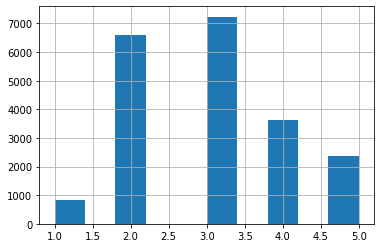

In [4]:
# Splitting income into bins, as this is the most important factor and adding as new column
housing['income_category'] = pd.cut(housing['median_income'],
                                    bins=[0, 1.5, 3, 4.5, 6, np.inf],
                                    labels=[1, 2, 3, 4, 5])
# Plotting new column
housing['income_category'].hist()

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit


# Create train & test set using income_category as primary discriminator
shuffle_split = StratifiedShuffleSplit(test_size=.2, random_state=20)
for train_index, test_index in shuffle_split.split(housing, housing['income_category']):
    train_set = housing.loc[train_index]
    housing_labels = train_set["median_house_value"].copy()
    test_set = housing.loc[test_index]

for set_ in (train_set, test_set):
    set_.drop('income_category', axis=1, inplace=True)
    
housing_train_set_copy = train_set.copy()

## Visualization of geographical data

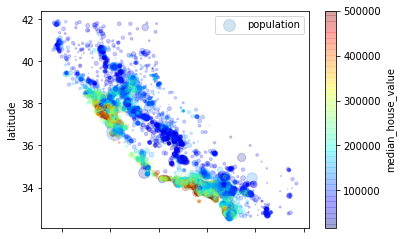

In [6]:
housing_train_set_copy.plot(kind='scatter', x='longitude', y='latitude', alpha=.2,
                            s=housing_train_set_copy['population'] / 100, label='population',
                            c='median_house_value', cmap=plt.get_cmap("jet"), colorbar=True)

## Correlation

Because the dataset is not too big, standard correlation coefficient can be calculated to see the correlation between each dataset column and the price of the housing.

In standard correlation coefficient value that is equal to 0 means that there is *negative correlation*, when indicator is equal to 1 then it is a *pefrect correlation*.

In [7]:
correlation_matrix = housing_train_set_copy.corr()
housing_correlation = correlation_matrix["median_house_value"].sort_values(ascending=False)
print(housing_correlation)

median_house_value    1.000000
median_income         0.689708
total_rooms           0.133057
housing_median_age    0.108125
households            0.064215
total_bedrooms        0.047561
population           -0.026533
longitude            -0.047809
latitude             -0.142165
Name: median_house_value, dtype: float64


## Forming new parameters

Certain data columns like number of bedrooms is not very useful in terms of the whole district. In this section these columns will be used to form a more meaningful parameters.

In [8]:
# housing_train_set_copy['rooms_per_household'] = housing_train_set_copy['total_rooms'] / housing_train_set_copy['households']
# housing_train_set_copy['bedrooms_per_room'] = housing_train_set_copy['total_bedrooms'] / housing_train_set_copy['total_rooms']
# housing_train_set_copy['population_per_household'] = housing_train_set_copy['population'] / housing_train_set_copy['households']

# corr_matrix = housing_train_set_copy.corr()
# housing_correlation = correlation_matrix["median_house_value"].sort_values(ascending=False)
# print(housing_correlation)

## Cleaning data

The dataset provided is not ideal, there are some missing data entries in some cells.

SKLearn SimpleInputer can be used to populate those cells with meaningful data.

In [9]:
from del_columns import del_columns

from sklearn.impute import SimpleImputer

housing_num = del_columns(housing_train_set_copy, "median_house_value")

imputer = SimpleImputer(strategy="median")

# Ocean proximity is not numeric, therefore has to be removed
print("Number of N/A cells before cleaning")
print(housing_num.isna().sum())
housing_num = del_columns(housing_num, "ocean_proximity")
imputer.fit(housing_num)
x = imputer.transform(housing_num)
housing_cleaned = pd.DataFrame(x, columns=housing_num.columns,
                               index=housing_num.index)
# Insert previously deleted columns
housing_cleaned["ocean_proximity"] = housing["ocean_proximity"]
housing_cleaned["median_house_value"] = housing["median_house_value"]
print("Number of N/A cells after cleaning")
print(housing_cleaned.isna().sum())

Number of N/A cells before cleaning
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        166
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64
Number of N/A cells after cleaning
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
ocean_proximity       0
median_house_value    0
dtype: int64


## Converting ocean proximity

ocean_proximity variable is an enum of type string. It can be converted to number using SKLearn OneHotEncoder.

In [10]:
from sklearn.preprocessing import OneHotEncoder


cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cleaned)

## Alterative approach - Pipelines

Because the preparing the data takes a lot of code to write, the above code can be replaced with SciKit pipelines.

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from combined_attributes_adder import CombinedAttributesAdder


num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [43]:
from sklearn.compose import ColumnTransformer


num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])
housing_prepared = full_pipeline.fit_transform(housing_train_set_copy)

## Training model

In [13]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Predictions

In [14]:
some_data = housing_train_set_copy.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [479766.6775398  356520.07790646 304579.73778371 257603.46602734
  98755.4781665 ]
Labels: [500001.0, 333700.0, 282200.0, 151900.0, 105300.0]


## RMSE of the model

In [15]:
from sklearn.metrics import mean_squared_error


housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(f"RMSE: {lin_rmse}")

RMSE: 68101.61929453643


## Decision Tree Regressor

In [16]:
from sklearn.tree import DecisionTreeRegressor


tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
print(f"RMSE: {tree_mse}")

RMSE: 0.0


## Cross Validation

In [17]:
from sklearn.model_selection import cross_val_score


scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
print(f"Tree RMSE: {tree_rmse_scores}")

Tree RMSE: [69038.09500581 65343.00399232 67982.41612119 70367.38493041
 73990.73374988 72556.7546342  73752.39232895 74388.83054707
 67599.1106733  70200.36396415]


In [18]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
print(f"Tree RMSE: {lin_rmse_scores}")

Tree RMSE: [67343.92406272 68273.5173648  67014.0212578  67864.50615765
 70947.27992923 69718.57445157 68312.9360604  71132.48907341
 67290.13510025 65174.6234801 ]


## Random Forest Regressor

In [19]:
from sklearn.ensemble import RandomForestRegressor


forest_reg = RandomForestRegressor(n_estimators=20)
forest_reg.fit(housing_prepared, housing_labels)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
print(f"Forest RMSE: {forest_rmse_scores}")

Forest RMSE: [50687.9436769  48763.60607287 51924.4613052  51548.78912532
 52920.84522603 52813.06269073 50816.78798073 52543.22073895
 50901.95634967 50279.76408537]


## Using grid search to find hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV


param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error',
                          return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)
grid_search.best_estimator_

## Importance of parameters

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

With this information, only one ocean_proximity is really useful (INLAND), the rest can be dropped.

## Evaluation on test set

In [ ]:
final_model = grid_search.best_estimator_
X_test = test_set
y_test = test_set['median_house_value'].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(f"Final RMSE: {final_rmse}")

# Support Vector Regressor (SVR)

SVR can be used to create a function that will separate dataset so that it will create the X number of sub-datasets with similar features.

In this example, we will group houses using average price.

In [16]:
from sklearn import svm

X_test = housing_prepared
y_test = housing_labels
clf = svm.SVR()
clf.fit(X_test, y_test)

C:\Users\User\.virtualenvs\machine-learning-jupyter-33F7vTu3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

## Evaluation on test

In [17]:
from sklearn.metrics import mean_squared_error


X_test = test_set
y_test = test_set['median_house_value'].copy()
X_test_prepared = full_pipeline.transform(X_test)
svm_predictions = clf.predict(X_test_prepared)
svm_mse = mean_squared_error(y_test, svm_predictions)
svm_rmse = np.sqrt(svm_mse)
print(f"Final RMSE: {svm_rmse}")

Final RMSE: 117589.58772390446


## Finding optimal C parameter value - GridSearchCV

In [51]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV


housing_limited = housing_prepared[:1000]
housing_labels_limited = housing_labels[:1000]
clf = svm.SVR()
param_grid = [
    {'kernel': ['linear'], 'C': [10, 20, 50, 100, 200, 500, 900, 1000]},
    {'kernel': ['rbf'], 'C': [10, 20, 50, 100, 200, 500, 900, 1000], 'gamma': [.001, .005, .01, .06, 1, 3]}
]
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_limited, housing_labels_limited)
final_clf = grid_search.best_estimator_
final_clf

SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

## Evaluation on test

In [32]:
from sklearn.metrics import mean_squared_error


X_test = test_set
y_test = test_set['median_house_value'].copy()
X_test_prepared = full_pipeline.transform(X_test)
svr_predictions = final_clf.predict(X_test_prepared)
svr_mse = mean_squared_error(y_test, svr_predictions)
svr_rmse = np.sqrt(svr_mse)
print(f"Final RMSE: {svr_rmse}")

Final RMSE: 71895.09830594539


## Finding optimal C parameter value - RandomizedSearchCV

In [24]:
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV


housing_limited = housing_prepared[:1000]
housing_labels_limited = housing_labels[:1000]
clf = svm.SVR()
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [10, 20, 50, 100, 200, 500, 900, 1000],
    'gamma': [.001, .005, .01, .06, 1, 3]
}
randomized_search = RandomizedSearchCV(clf, param_grid, cv=5, scoring='neg_mean_squared_error',
                                      return_train_score=True, random_state=40)
randomized_search.fit(housing_limited, housing_labels_limited)
final_clf = randomized_search.best_estimator_
randomized_search.best_params_

{'kernel': 'linear', 'gamma': 0.001, 'C': 900}

## Evaluation on test

In [18]:
from sklearn.metrics import mean_squared_error


X_test = test_set
y_test = test_set['median_house_value'].copy()
X_test_prepared = full_pipeline.transform(X_test)
svr_predictions = final_clf.predict(X_test_prepared)
svr_mse = mean_squared_error(y_test, svr_predictions)
svr_rmse = np.sqrt(svr_mse)
print(f"Final RMSE: {svr_rmse}")

Final RMSE: 71843.20080590209


## Pipeline improvements

Tramsformation pipeline declared previously can be improved by adding a function that will select the most important attributes.

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from combined_attributes_adder import CombinedAttributesAdder
from sklearn.feature_selection import SelectKBest, f_classif


num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
    ('top_attributes_selector', SelectKBest(score_func=f_classif, k=7))
])

In [31]:
from sklearn.compose import ColumnTransformer


num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_limited = housing_train_set_copy[:1000]
housing_labels_limited = housing_labels[:1000]
housing_prepared = full_pipeline.fit_transform(housing_limited, housing_labels_limited)

## Pipeline with SVR prediciton

In [49]:
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from combined_attributes_adder import CombinedAttributesAdder
from sklearn.feature_selection import SelectKBest, f_classif


prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('top_attributes_selector', SelectKBest(score_func=f_classif, k=7)),
    ('svm_reg', svm.SVR(**randomized_search.best_params_))
])


housing_limited = housing_train_set_copy[:1000]
housing_labels_limited = housing_labels[:1000]
housing_prepared = prepare_select_and_predict_pipeline.fit(housing_limited, housing_labels_limited)

## Evaluation on test

In [50]:
from sklearn.metrics import mean_squared_error


X_test = test_set
y_test = test_set['median_house_value'].copy()
X_test_prepared = full_pipeline.transform(X_test)
svr_predictions = final_clf.predict(X_test_prepared)
svr_mse = mean_squared_error(y_test, svr_predictions)
svr_rmse = np.sqrt(svr_mse)
print(f"Final RMSE: {svr_rmse}")

Final RMSE: 128687.78425371654
